# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import ujson
import tqdm

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "../data/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [7]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [9]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int8), array([15028, 16670]))

#### Обучим случайный лес

In [10]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 48.6 s, sys: 182 ms, total: 48.8 s
Wall time: 6.6 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [11]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [12]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [13]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [14]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                            index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [15]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(''.join(['../data/', submission_filename]))
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-31_10-20-10.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [16]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [17]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 11.8 s, sys: 981 ms, total: 12.8 s
Wall time: 47.1 s


In [18]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [19]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [20]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строк
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [21]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [22]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

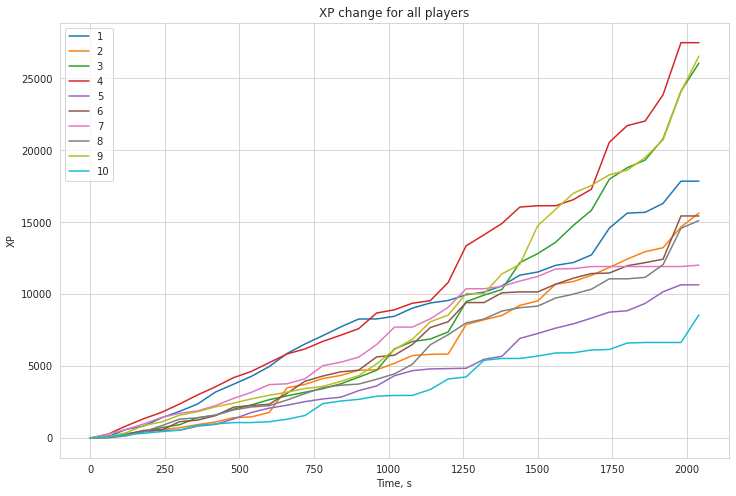

In [23]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [24]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [25]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [26]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [27]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [28]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 111 ms, sys: 133 ms, total: 243 ms
Wall time: 1min 20s


In [29]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

# Прочитаем побольше всего

In [30]:
def add_new_features(df_features, matches_file, total_matches=31698):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file, total_matches=total_matches):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        # и другие данные
        first_blood = 0
        aegis_stolen_radiant, aegis_stolen_dire = 0, 0
        aegis_denied_radiant, aegis_denied_dire = 0, 0
        radiant_roshan_kills, dire_roshan_kills = 0, 0
        barracks_kill = 0
        dire_ability_uses = 0
        rad_ability_uses = 0
        
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1
            if objective["type"] == "CHAT_MESSAGE_ROSHAN_KILL":
                if objective["team"] == 2:
                    radiant_roshan_kills += 1
                if objective["team"] == 3:
                    dire_roshan_kills += 1
                    
            if objective["type"] == "CHAT_MESSAGE_BARRACKS_KILL":
                barracks_kill += 1
                    
            if objective["type"] == "CHAT_MESSAGE_FIRSTBLOOD":
                if objective["player_slot"] < 6:
                    first_blood = 1
                    
            if objective["type"] == "CHAT_MESSAGE_AEGIS_STOLEN":
                if objective["player_slot"] < 6:
                    aegis_stolen_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_stolen_dire += 1
            
            if objective["type"] == "CHAT_MESSAGE_DENIED_AEGIS":
                if objective["player_slot"] < 6:
                    aegis_denied_radiant += 1
                if objective["player_slot"] > 50:
                    aegis_denied_dire += 1
                    
                
        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        df_features.loc[match_id_hash, "radiant_roshan_kills"] = radiant_roshan_kills
        df_features.loc[match_id_hash, "dire_roshan_kills"] = dire_roshan_kills
        df_features.loc[match_id_hash, "diff_roshan_kills"] = radiant_roshan_kills - dire_roshan_kills
        
        df_features.loc[match_id_hash, "first_blood"] = first_blood
        df_features.loc[match_id_hash, "barracks_kill"] = barracks_kill       
        
        df_features.loc[match_id_hash, "aegis_stolen_diff"] = aegis_stolen_radiant - aegis_stolen_dire
        df_features.loc[match_id_hash, "aegis_stolen_radiant"] = aegis_stolen_radiant
        df_features.loc[match_id_hash, "aegis_stolen_dire"] = aegis_stolen_dire
            
        df_features.loc[match_id_hash, "aegis_denied_diff"] = aegis_denied_radiant - aegis_denied_dire
        df_features.loc[match_id_hash, "aegis_denied_radiant"] = aegis_denied_radiant
        df_features.loc[match_id_hash, "aegis_denied_dire"] = aegis_denied_dire
        
        for player in match["players"]:
            if player['player_slot'] > 90:
                for i in player["ability_uses"].values():
                    dire_ability_uses += i
            else:
                for i in player["ability_uses"].values():
                    rad_ability_uses += i
        
        df_features.loc[match_id_hash, "rad_ability_uses"] = rad_ability_uses
        df_features.loc[match_id_hash, "dire_ability_uses"] = dire_ability_uses 
        
        
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [31]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

## <left>Feature engineering

In [104]:
train = df_train_features_extended.copy()

<AxesSubplot:>

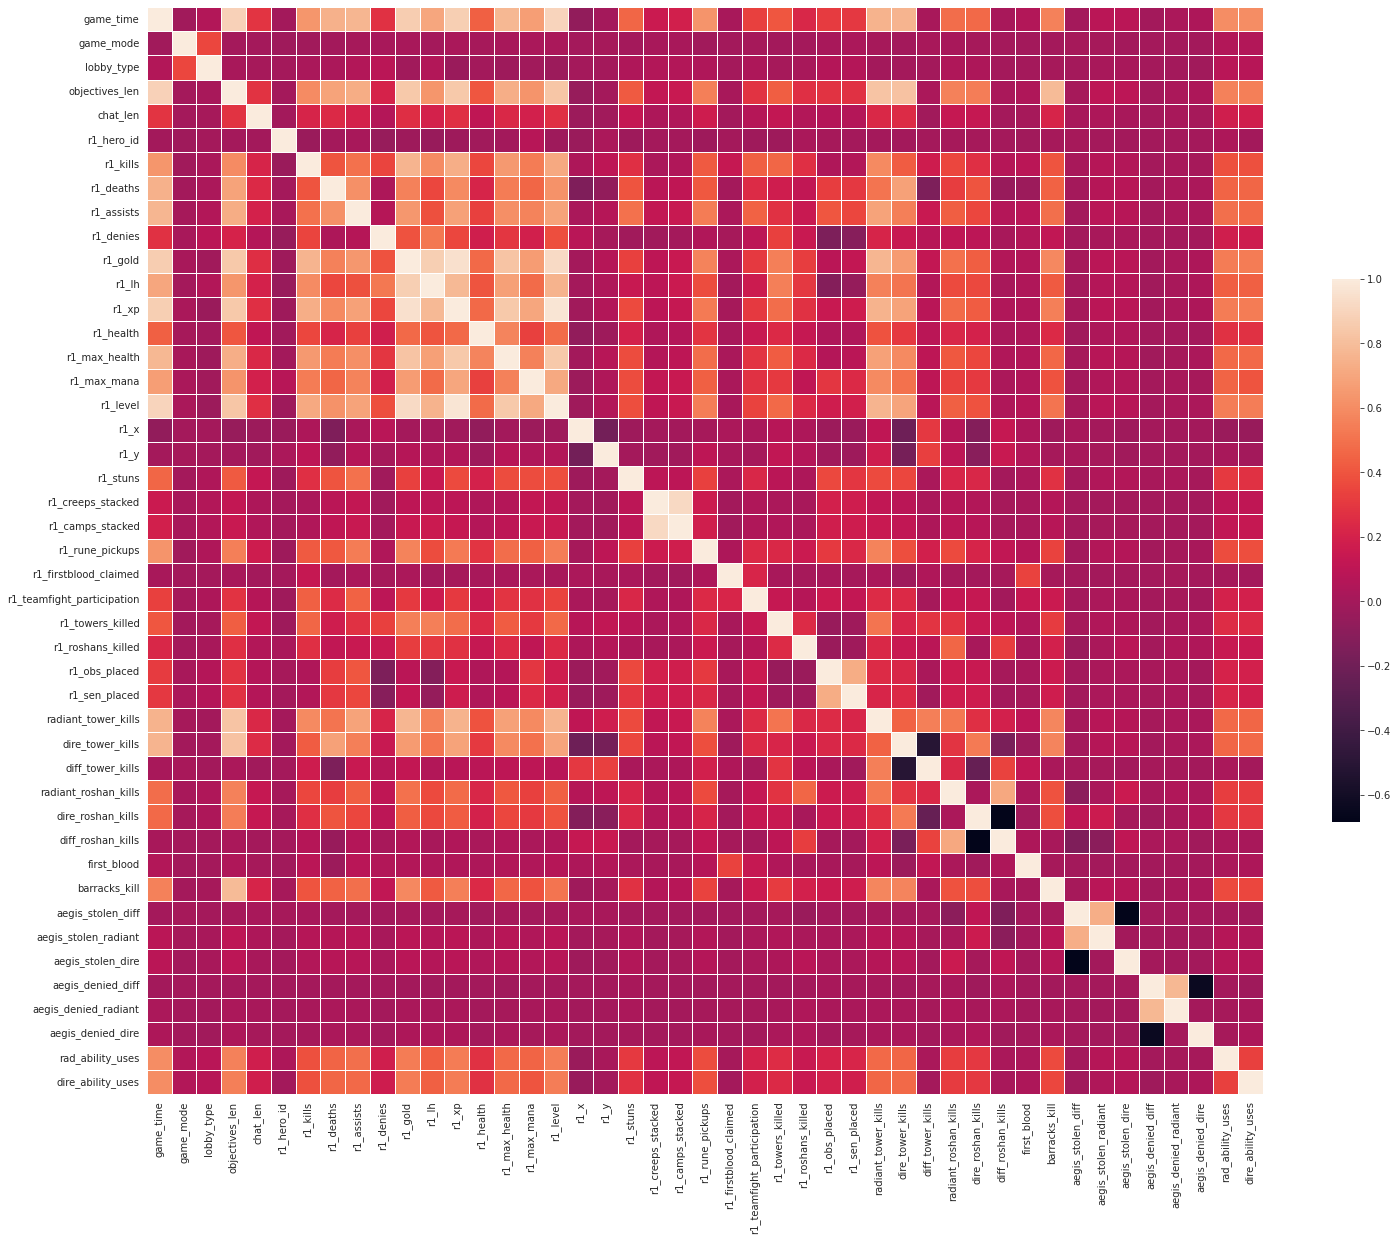

In [105]:
plt.figure(figsize=(25, 20))

sns.heatmap(train[['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len', 
                                        'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies', 'r1_gold', 
                                        'r1_lh', 'r1_xp', 'r1_health', 'r1_max_health', 'r1_max_mana', 'r1_level', 
                                        'r1_x', 'r1_y', 'r1_stuns', 'r1_creeps_stacked', 'r1_camps_stacked', 
                                        'r1_rune_pickups', 'r1_firstblood_claimed', 'r1_teamfight_participation', 
                                        'r1_towers_killed', 'r1_roshans_killed', 'r1_obs_placed', 'r1_sen_placed',
                                        'radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills', 'radiant_roshan_kills', 
                                        'dire_roshan_kills', 'diff_roshan_kills', 'first_blood', 'barracks_kill', 
                                        'aegis_stolen_diff', 'aegis_stolen_radiant', 'aegis_stolen_dire', 'aegis_denied_diff', 
                                        'aegis_denied_radiant', 'aegis_denied_dire', 'rad_ability_uses', 
                                        'dire_ability_uses'
                                       ]].corr(),
            linewidths=0.5, 
            cbar_kws={"shrink": 0.5})

In [107]:
for i in range(1, 6):    
    train[f'd{i}_KDA'] = (train[f'd{i}_kills'] + train[f'd{i}_assists'] + 2) / (train[f'd{i}_deaths'] + 1)
    train[f'r{i}_KDA'] = (train[f'r{i}_kills'] + train[f'r{i}_assists'] + 2) / (train[f'r{i}_deaths'] + 1)
    
    train = train.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                        f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                      axis=1)

In [35]:
for i in range(1, 6):
    train = train.drop([f'd{i}_roshans_killed',
                        f'r{i}_roshans_killed'],
                      axis=1)

<AxesSubplot:>

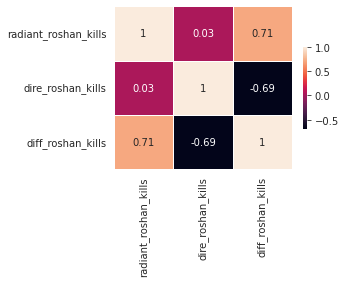

In [36]:
plt.figure(figsize=(4, 3))
sns.heatmap(train[['radiant_roshan_kills', 'dire_roshan_kills', 'diff_roshan_kills'    
]].corr(),
            linewidths=0.5, 
            annot=True,
            cbar_kws={"shrink": 0.5})

In [37]:
for i in range(1, 6):
    train = train.drop([f'd{i}_level',
                        f'r{i}_level'],
                      axis=1)

In [38]:
train['r_creeps_stacked'] = 0
train['d_creeps_stacked'] = 0
train['r_camps_stacked'] = 0
train['d_camps_stacked'] = 0


for i in range(1, 6):
    train['r_creeps_stacked'] += train[f'r{i}_creeps_stacked'] 
    train['d_creeps_stacked'] += train[f'd{i}_creeps_stacked'] 
    
    train['r_camps_stacked'] += train[f'r{i}_camps_stacked'] 
    train['d_camps_stacked'] += train[f'd{i}_camps_stacked'] 
    
    train = train.drop([f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                        f'r{i}_camps_stacked', f'd{i}_camps_stacked'],
                      axis=1)

In [39]:
train['r_lh'] = 0
train['d_lh'] = 0


for i in range(1, 6):
    train['r_lh'] += train[f'r{i}_lh'] 
    train['d_lh'] += train[f'd{i}_lh']
    
    train = train.drop([f'r{i}_lh',
                        f'd{i}_lh'],
                      axis=1)

In [40]:
train['diff_lh'] = train['r_lh'] - train['d_lh']

train = train.drop(['r_lh',
                    'd_lh'],
                    axis=1)

In [41]:
train['diff_camps_stacked'] = train['r_creeps_stacked'] - train['d_creeps_stacked']
train['diff_creeps_stacked'] = train['r_camps_stacked'] - train['d_camps_stacked']

train = train.drop(['d_creeps_stacked', 'r_creeps_stacked',
                    'd_camps_stacked', 'r_camps_stacked'],
                    axis=1)

In [42]:
train['d_gold'] = 0
train['r_gold'] = 0

for i in range(1, 6):
    train['d_gold'] += train[f'r{i}_gold'] 
    train['r_gold'] += train[f'd{i}_gold'] 
    
    train = train.drop([f'r{i}_gold',
                        f'd{i}_gold',],
                      axis=1)

In [43]:
train['diff_gold'] = train['r_gold'] - train['d_gold']

train = train.drop(['d_gold', 
                    'r_gold'],
                    axis=1)

In [44]:
train['d_xp'] = 0
train['r_xp'] = 0

for i in range(1, 6):
    train['d_xp'] += train[f'r{i}_xp'] 
    train['r_xp'] += train[f'd{i}_xp'] 
    
    train = train.drop([f'r{i}_xp',
                        f'd{i}_xp',],
                      axis=1)
    
train['diff_xp'] = train['r_xp'] - train['d_xp']

train = train.drop(['d_xp', 
                    'r_xp'],
                    axis=1)

In [45]:
# до этого было Score: 0.82640

In [46]:
# id hero to hero win rate

id_hero = set(list(train['r1_hero_id']))

new_train = train.copy()
new_train['win'] = y

win_rate_for_hero = dict()

for index, row in train.iterrows():
    for i in range(1, 6):
        try:
            win_rate_for_hero[row[f'r{i}_hero_id']] += new_train.loc[index, 'win']

        except KeyError:
            win_rate_for_hero[row[f'r{i}_hero_id']] = new_train.loc[index, 'win']
            
        try:
            win_rate_for_hero[row[f'd{i}_hero_id']] += new_train.loc[index, 'win']

        except KeyError:
            win_rate_for_hero[row[f'd{i}_hero_id']] = new_train.loc[index, 'win']
            
for h_id in win_rate_for_hero:
    win_rate_for_hero[h_id] = win_rate_for_hero[h_id] / new_train.shape[0]
    
for index, row in new_train.iterrows():
    for i in range(1, 6):
        train.loc[index, f"r{i}h_win_rate"] = win_rate_for_hero[row[f"r{i}_hero_id"]]
        train.loc[index, f"d{i}h_win_rate"] = win_rate_for_hero[row[f"d{i}_hero_id"]]
    
for i in range(1, 6):
    train = train.drop([f"r{i}_hero_id", f"d{i}_hero_id"], axis=1)

In [47]:
# после этого скор =  0.82628

In [48]:
train['r_first_blood'] = 0
train['d_first_blood'] = 0

for i in range(1, 6):
    train['r_first_blood'] += train[f'r{i}_firstblood_claimed']
    train['d_first_blood'] += train[f'd{i}_firstblood_claimed']
    
    train = train.drop([f'r{i}_firstblood_claimed',
                        f'd{i}_firstblood_claimed',],
                      axis=1)

In [49]:
train['first_blood'] = train['r_first_blood'] - train['d_first_blood']

train = train.drop(['r_first_blood', 'd_first_blood'], axis=1)

In [50]:
train['r_max_mana'] = 0
train['d_max_mana'] = 0

for i in range(1, 6):
    train['r_max_mana'] += train[f'r{i}_max_mana']
    train['d_max_mana'] += train[f'd{i}_max_mana']
    
    train = train.drop([f'r{i}_max_mana',
                        f'd{i}_max_mana'],
                      axis=1)
    
train['diff_max_mana'] = train['r_max_mana'] - train['d_max_mana']

train = train.drop(['r_max_mana', 'd_max_mana'], axis=1)

In [51]:
# 0.82668

In [52]:
train['diff_creeps_a_camps_stacked'] = train['diff_camps_stacked'] + train['diff_creeps_stacked']

train = train.drop(['diff_camps_stacked', 'diff_creeps_stacked'], axis=1)

train = train.drop(['objectives_len'], axis=1)

In [53]:
# 0.82784

# Подготовим данные теста

In [54]:
df_test_features = pd.read_csv(os.path.join('../data', "test_data.csv"), 
                                            index_col="match_id_hash")

test = df_test_features.copy()

In [55]:
# Скопируем таблицу с признаками

# Добавим новые
add_new_features(test, 
                 os.path.join('../data', 
                              "test_raw_data.jsonl"),
                total_matches = 7977)

  0%|          | 0/7977 [00:00<?, ?it/s]

In [56]:
df_test = test.copy()

In [57]:
for i in range(1, 6):    
    df_test[f'd{i}_KDA'] = np.where(df_test[f'd{i}_deaths'] != 0, 
                                    (df_test[f'd{i}_kills'] + df_test[f'd{i}_assists']) / df_test[f'd{i}_deaths'],
                                    df_test[f'd{i}_kills'] + df_test[f'd{i}_assists'])
        
    df_test[f'r{i}_KDA'] = np.where(df_test[f'r{i}_deaths'] != 0, 
                                    (df_test[f'r{i}_kills'] + df_test[f'r{i}_assists']) / df_test[f'r{i}_deaths'],
                                    df_test[f'r{i}_kills'] + df_test[f'r{i}_assists'])
    
    df_test = df_test.drop([f'd{i}_kills', f'd{i}_assists', f'd{i}_deaths',
                            f'r{i}_kills', f'r{i}_assists', f'r{i}_deaths'],
                            axis=1)

In [58]:
for i in range(1, 6):
    df_test = df_test.drop([f'd{i}_roshans_killed',
                            f'r{i}_roshans_killed'],
                            axis=1)

In [59]:
for i in range(1, 6):
    df_test = df_test.drop([f'd{i}_level',
                        f'r{i}_level'],
                      axis=1)

In [60]:
df_test['r_creeps_stacked'] = 0
df_test['d_creeps_stacked'] = 0
df_test['r_camps_stacked'] = 0
df_test['d_camps_stacked'] = 0


for i in range(1, 6):
    df_test['r_creeps_stacked'] += df_test[f'r{i}_creeps_stacked'] 
    df_test['d_creeps_stacked'] += df_test[f'd{i}_creeps_stacked'] 
    
    df_test['r_camps_stacked'] += df_test[f'r{i}_camps_stacked'] 
    df_test['d_camps_stacked'] += df_test[f'd{i}_camps_stacked'] 
    
    df_test = df_test.drop([f'r{i}_creeps_stacked', f'd{i}_creeps_stacked',
                        f'r{i}_camps_stacked', f'd{i}_camps_stacked'],
                      axis=1)

In [61]:
df_test['r_lh'] = 0
df_test['d_lh'] = 0


for i in range(1, 6):
    df_test['r_lh'] += df_test[f'r{i}_lh'] 
    df_test['d_lh'] += df_test[f'd{i}_lh']
    
    df_test = df_test.drop([f'r{i}_lh',
                            f'd{i}_lh'],
                              axis=1)

In [62]:
df_test['diff_lh'] = df_test['r_lh'] - df_test['d_lh']

df_test = df_test.drop(['r_lh',
                        'd_lh'],
                        axis=1)

In [63]:
df_test['diff_camps_stacked'] = df_test['r_creeps_stacked'] - df_test['d_creeps_stacked']
df_test['diff_creeps_stacked'] = df_test['r_camps_stacked'] - df_test['d_camps_stacked']

df_test = df_test.drop(['d_creeps_stacked', 'r_creeps_stacked',
                    'd_camps_stacked', 'r_camps_stacked'],
                    axis=1)

In [64]:
df_test['d_gold'] = 0
df_test['r_gold'] = 0

for i in range(1, 6):
    df_test['d_gold'] += df_test[f'r{i}_gold'] 
    df_test['r_gold'] += df_test[f'd{i}_gold'] 
    
    df_test = df_test.drop([f'r{i}_gold',
                            f'd{i}_gold',],
                            axis=1)

In [65]:
df_test['diff_gold'] = df_test['r_gold'] - df_test['d_gold']

df_test = df_test.drop(['d_gold', 
                        'r_gold'],
                        axis=1)

In [66]:
df_test['d_xp'] = 0
df_test['r_xp'] = 0

for i in range(1, 6):
    df_test['d_xp'] += df_test[f'r{i}_xp'] 
    df_test['r_xp'] += df_test[f'd{i}_xp'] 
    
    df_test = df_test.drop([f'r{i}_xp',
                        f'd{i}_xp',],
                      axis=1)
    
df_test['diff_xp'] = df_test['r_xp'] - df_test['d_xp']

df_test = df_test.drop(['d_xp', 
                    'r_xp'],
                    axis=1)

In [67]:
# 8.2

In [68]:
# id hero to hero win rate

for index, row in df_test.iterrows():
    for i in range(1, 6):
        df_test.loc[index, f"r{i}h_win_rate"] = win_rate_for_hero[row[f"r{i}_hero_id"]]
        df_test.loc[index, f"d{i}h_win_rate"] = win_rate_for_hero[row[f"d{i}_hero_id"]]
    
for i in range(1, 6):
    df_test = df_test.drop([f"r{i}_hero_id", f"d{i}_hero_id"], axis=1)

In [69]:
#  0.82628

In [70]:
df_test['r_first_blood'] = 0
df_test['d_first_blood'] = 0

for i in range(1, 6):
    df_test['r_first_blood'] += df_test[f'r{i}_firstblood_claimed']
    df_test['d_first_blood'] += df_test[f'd{i}_firstblood_claimed']
    
    df_test = df_test.drop([f'r{i}_firstblood_claimed',
                        f'd{i}_firstblood_claimed',],
                      axis=1)

In [71]:
df_test['first_blood'] = df_test['r_first_blood'] - df_test['d_first_blood']

df_test = df_test.drop(['r_first_blood', 'd_first_blood'], axis=1)

In [72]:
df_test['r_max_mana'] = 0
df_test['d_max_mana'] = 0

for i in range(1, 6):
    df_test['r_max_mana'] += df_test[f'r{i}_max_mana']
    df_test['d_max_mana'] += df_test[f'd{i}_max_mana']
    
    df_test = df_test.drop([f'r{i}_max_mana',
                        f'd{i}_max_mana'],
                      axis=1)
    
df_test['diff_max_mana'] = df_test['r_max_mana'] - df_test['d_max_mana']

df_test = df_test.drop(['r_max_mana', 'd_max_mana'], axis=1)

In [73]:
# 0.82668

In [74]:
df_test['diff_creeps_a_camps_stacked'] = df_test['diff_camps_stacked'] + df_test['diff_creeps_stacked']

df_test = df_test.drop(['diff_camps_stacked', 'diff_creeps_stacked'], axis=1)

df_test = df_test.drop(['objectives_len'], axis=1)

In [108]:
# 0.82784

# Scaler

In [86]:
X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

In [87]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# Тест получившегося

In [88]:
%%time

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7778841417472704
CPU times: user 10.3 s, sys: 1.04 s, total: 11.3 s
Wall time: 38.2 s


In [89]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

In [90]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

ROC-AUC score на отложенной части: 0.7779986840532014
Accuracy score (p > 0.5) на отложенной части: 0.6982124079915878


In [92]:
parameters = {'criterion': ['gini'], 
              'n_estimators': range(50, 500, 40),
              'max_depth': range(2, 15, 2), 
              'min_samples_split': range(2, 6, 2),
              'min_samples_leaf' : range(2, 6, 2)}

# собственно сам тюнинг
cls_m = RandomForestClassifier(random_state=SEED)
grid_search_cv_cls = GridSearchCV(cls_m, parameters, cv=3, n_jobs=-1, scoring="roc_auc")

grid_search_cv_cls.fit(X_train, y_train)

cls_dgs_best = grid_search_cv_cls.best_estimator_

print(grid_search_cv_cls.best_params_)
print(grid_search_cv_cls.best_estimator_)

{'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 410}
RandomForestClassifier(max_depth=14, min_samples_leaf=4, n_estimators=410,
                       random_state=10801)


In [ ]:
cls_best = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                                  n_estimators=400, n_jobs=-1, random_state=SEED)

cls_best.fit(X_train, y_train)

y_pred = cls_best.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

# Другие модели

In [94]:
import seaborn as sns
import catboost
import xgboost
import lightgbm
from sklearn.ensemble import (VotingClassifier, ExtraTreesClassifier)
from sklearn.preprocessing import StandardScaler

from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

## 1. LR

In [95]:
lr = LogisticRegression(solver='liblinear', max_iter=10000)

lr.fit(X_train, y_train)
scores = cross_val_score(lr, X_train, y_train, cv=3, scoring="roc_auc")
print(f"{lr.__class__.__name__}: {scores.mean()}")

y_pred = lr.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

LogisticRegression: 0.8069993048250255
ROC-AUC score на отложенной части: 0.8058114094609797
Accuracy score (p > 0.5) на отложенной части: 0.7192429022082019


Text(15.0, 0.5, 'Truth')

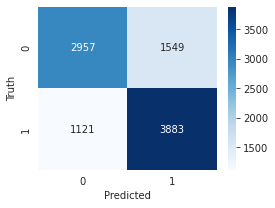

In [96]:
y_pred = lr.predict(X_valid)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)


plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [97]:
parameters = {'penalty': ['l1','l2'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
              'class_weight': ['None', 'balanced'],
              'max_iter': range(1000, 10000, 1000)}

lr = LogisticRegression(random_state=SEED)
grid_search_lr = GridSearchCV(lr, parameters, cv=3, n_jobs=-1, scoring="roc_auc")

grid_search_lr.fit(X_train, y_train)

lr_best = grid_search_lr.best_estimator_

print(grid_search_lr.best_params_)
print(grid_search_lr.best_estimator_)

/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/

/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/

AttributeError: 'LogisticRegression' object has no attribute 'best_params_'

In [98]:
print(grid_search_lr.best_params_)
print(grid_search_lr.best_estimator_)

{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=10801, solver='liblinear')


Text(15.0, 0.5, 'Truth')

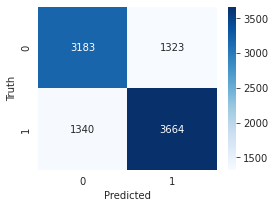

In [100]:
y_pred = lr_best.predict(X_valid)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')

## 2. Voting

In [ ]:
rf = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                            n_estimators=400, n_jobs=-1, random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)

base_models = [("RF", rf), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')

In [ ]:
voting_soft.fit(X_train_scaled, y_train)
scores = cross_val_score(voting_soft, X_train_scaled, y_train, cv=3, scoring="roc_auc")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")

y_pred = voting_soft.predict_proba(X_valid_scaled)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

In [ ]:
# y_pred_best

y_pred = voting_soft.predict(X_valid_scaled)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap=plt.cm.Blues, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [88]:
# Score 0.82858

In [ ]:
# больше голосований

In [83]:
dt = DecisionTreeClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=25, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

SyntaxError: invalid syntax (3721358138.py, line 1)

In [ ]:
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')

voting_soft.fit(X_train, y_train)
scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="roc_auc")
print(f"{voting_soft.__class__.__name__}: {scores.mean()}")

y_pred = voting_soft.predict_proba(X_valid)[:, 1]

valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

In [ ]:
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
cat.fit(X_train, y_train)
etc.fit(X_train, y_train)
knn.fit(X_train, y_train)
svc_lin.fit(X_train, y_train)
svc_rbf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
xgb_rf.fit(X_train, y_train)
lgbm_rf.fit(X_train, y_train)
lr.fit(X_train, y_train)
nb.fit(X_train, y_train)
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="roc_auc")
    print(f"{model.__class__.__name__}: {scores.mean()}")

In [ ]:
# y_pred_best
y_pred = voting_soft.predict(X_valid)

conf_mat = confusion_matrix(y_true=y_valid, y_pred=y_pred)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [ ]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]

    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
correlations = base_model_pair_correlation_for_voting_clf(voting_soft, X_train)

sorted(correlations, key=lambda x: x[-1], reverse=True)

# Подготовим посылку

In [85]:
# RF
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(train, y)

y_test_pred = rf_model.predict_proba(df_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-30_21-43-23.csv


In [101]:
# Grid RF
# 0.83050 Score
rf_model = RandomForestClassifier(max_depth=14, min_samples_leaf=4,
                                  n_estimators=400, n_jobs=-1, random_state=SEED)
rf_model.fit(train, y)

y_test_pred = rf_model.predict_proba(df_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-31_15-16-30.csv


In [103]:
# voting
# 0.83085 score

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(df_test)

rf = RandomForestClassifier(max_depth=14, 
                            min_samples_leaf=4,
                            n_estimators=400, 
                            n_jobs=-1, 
                            random_state=SEED)

lr = LogisticRegression(C=0.1, 
                        class_weight='balanced', 
                        max_iter=1000, 
                        penalty='l1',
                        solver='liblinear', 
                        random_state=SEED)

base_models = [("RF", rf), 
               ("LR", lr)]

voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')
voting_soft.fit(train_scaled, y)

y_test_pred = voting_soft.predict_proba(test_scaled)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

df_submission.to_csv(''.join(['../data/', submission_filename]))

print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-31_15-18-21.csv


# GS